In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
# metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    confusion_matrix
)

In [4]:
# =================================================
# LOAD + PREPROCESS DATA
# =================================================
df = pd.read_csv("adult.csv")

df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

In [5]:
y = df["income"].map({"<=50K": 0, ">50K": 1})
X = df.drop("income", axis=1)

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
def evaluate_and_save(model, model_name):

    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = y_pred

    # ===== metrics =====
    scores = [
        accuracy_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        matthews_corrcoef(y_test, y_pred)
    ]

    # ===== confusion matrix =====
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()
    ax.imshow(cm)

    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center")

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"{model_name} Confusion Matrix")

    # Create the directory if it doesn't exist
    os.makedirs("confusion_matrices", exist_ok=True)
    plt.savefig(f"confusion_matrices/{model_name}_cm.png")
    plt.close()

    return scores

In [7]:
# =================================================
# DEFINE 6 MODELS
# =================================================
models = {
    "Logistic_Regression": LogisticRegression(max_iter=1000),
    "Decision_Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive_Bayes": GaussianNB(),
    "Random_Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}


In [8]:
# =================================================
# TRAIN + EVALUATE ALL
# =================================================
import joblib
import os

results = []

# Create the models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

for name, clf in models.items():

    print(f"Training {name}...")

    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", clf)
    ])

    pipe.fit(X_train, y_train)

    # Save the trained model
    joblib.dump(pipe, f"models/{name}.pkl")

    scores = evaluate_and_save(pipe, name)

    results.append([name] + scores)


Training Logistic_Regression...
Training Decision_Tree...
Training KNN...
Training Naive_Bayes...
Training Random_Forest...
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:13:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [9]:
# =================================================
# SAVE RESULTS TABLE
# =================================================
columns = [
    "Model",
    "Accuracy",
    "AUC",
    "Precision",
    "Recall",
    "F1",
    "MCC"
]

results_df = pd.DataFrame(results, columns=columns)

print("\nMODEL COMPARISON TABLE")
print(results_df)

results_df.to_csv("model_results.csv", index=False)


MODEL COMPARISON TABLE
                 Model  Accuracy       AUC  Precision    Recall        F1  \
0  Logistic_Regression  0.845992  0.904650   0.731588  0.598127  0.658160   
1        Decision_Tree  0.805970  0.747334   0.603927  0.631133  0.617230   
2                  KNN  0.824876  0.852031   0.665660  0.589652  0.625355   
3          Naive_Bayes  0.644776  0.850683   0.404636  0.918822  0.561844   
4        Random_Forest  0.845550  0.900425   0.721785  0.613292  0.663130   
5              XGBoost  0.865782  0.924871   0.767708  0.657449  0.708313   

        MCC  
0  0.564786  
1  0.487575  
2  0.513233  
3  0.411974  
4  0.566941  
5  0.624979  


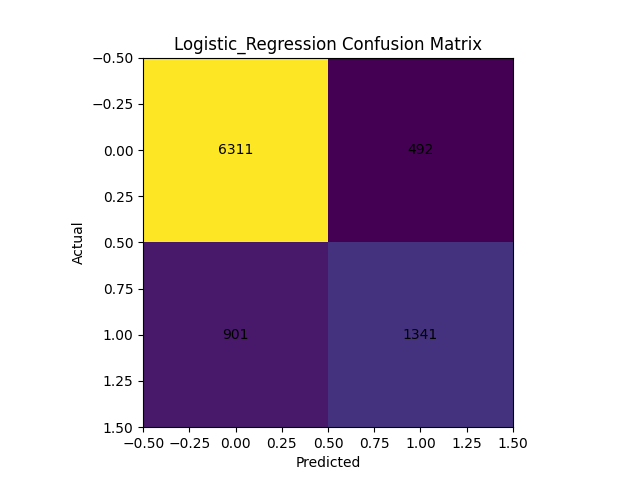

In [10]:
from IPython.display import Image
Image('confusion_matrices/Logistic_Regression_cm.png')

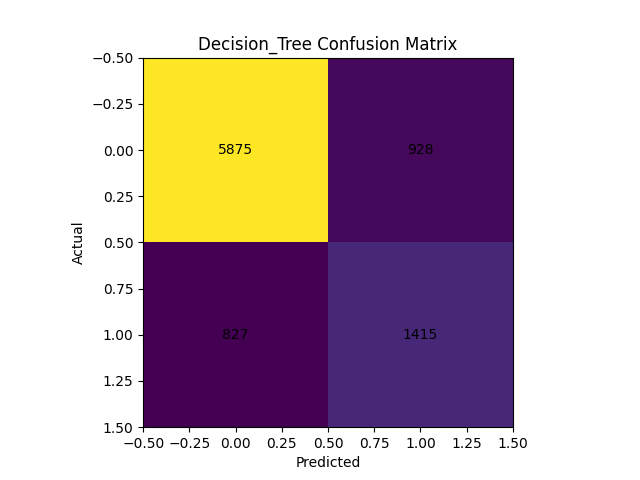

In [11]:
from IPython.display import Image
Image('confusion_matrices/Decision_Tree_cm.png')

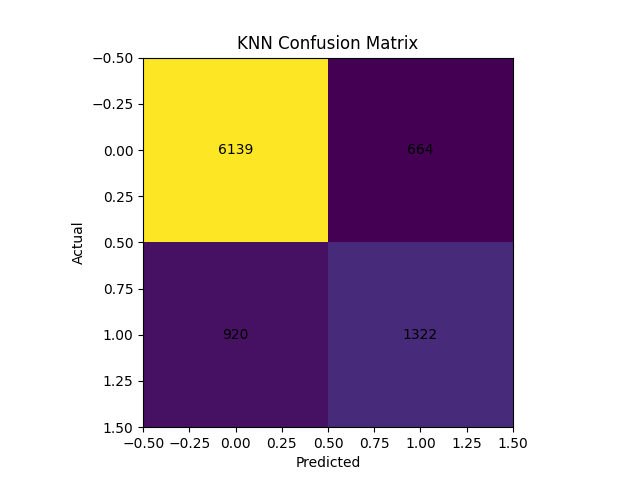

In [12]:
from IPython.display import Image
Image('confusion_matrices/KNN_cm.png')

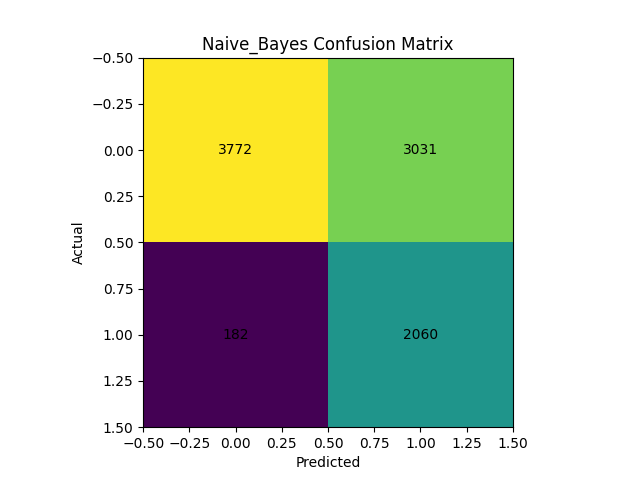

In [13]:
from IPython.display import Image
Image('confusion_matrices/Naive_Bayes_cm.png')

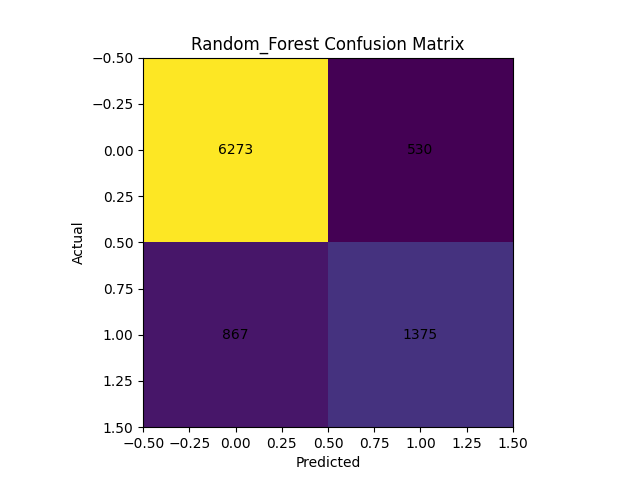

In [14]:
from IPython.display import Image
Image('confusion_matrices/Random_Forest_cm.png')

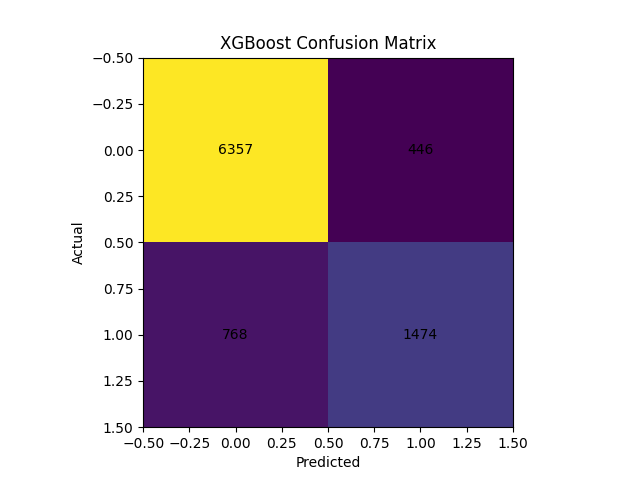

In [15]:
from IPython.display import Image
Image('confusion_matrices/XGBoost_cm.png')